# **DATA ANALYTICS COMPETITION ITS**
TEAM : SDM Tinggi

Participant Number : 0187

Universitas Atma Jaya Yogyakarta
*   Kevin Philips Tanamas
*   Richard Angelico Pudjohartono







**Overview of Model Implementation:**

In this project, we implemented a hybrid Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) model to predict time-series data. The dataset was preprocessed, including encoding categorical features and normalizing the data. The model architecture leveraged the strengths of CNNs for feature extraction and LSTM for capturing temporal dependencies, making it suitable for complex sequential data.

## **LOAD & MERGE DATA**



In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import os
import altair as alt
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype

from google.colab import files
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, InputLayer, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from google drive

train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/test.csv")
data_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/solar-irradiance"
weather_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Weather.csv")

print(os.listdir(data_path))

['Solar_Irradiance_2016.csv', 'Solar_Irradiance_2014.csv', 'Solar_Irradiance_2015.csv', 'Solar_Irradiance_2017.csv']


In [ ]:
# Combine dataframe from solar irradiance and weather files

irradiance_files = os.listdir(data_path)
irradiance_data_list = [pd.read_csv(os.path.join(data_path, file)) for file in irradiance_files if file.endswith('.csv')]
solar_irradiance_data = pd.concat(irradiance_data_list, ignore_index=True)

solar_irradiance_data['Timestamp'] = pd.to_datetime(solar_irradiance_data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
print(solar_irradiance_data.head())

   Year  Month  Day  Hour  Minute  DHI  DNI  GHI  Clearsky DHI  Clearsky DNI  \
0  2016      1    1     0       0  0.0  0.0  0.0           0.0           0.0   
1  2016      1    1     1       0  0.0  0.0  0.0           0.0           0.0   
2  2016      1    1     2       0  0.0  0.0  0.0           0.0           0.0   
3  2016      1    1     3       0  0.0  0.0  0.0           0.0           0.0   
4  2016      1    1     4       0  0.0  0.0  0.0           0.0           0.0   

   Clearsky GHI          Cloud Type  Dew Point  Solar Zenith Angle  \
0           0.0      Probably Clear          1              124.08   
1           0.0         Overlapping          1              135.16   
2           0.0         Overlapping          1              145.83   
3           0.0  Super-Cooled Water          0              155.13   
4           0.0         Overlapping          0              160.60   

   Surface Albedo  Wind Speed  Relative Humidity  Temperature  Pressure  \
0           0.108      

In [ ]:
# Train & Test Data type convertion to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%b %d, %Y %I%p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%b %d, %Y %I%p')
weather_data['date_time'] = pd.to_datetime(weather_data['date_time'])

In [ ]:
# Combine all train & test data
combined_data = pd.merge(solar_irradiance_data, weather_data, left_on='Timestamp', right_on='date_time', how='left')
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
train_merged = pd.merge(train_data, combined_data, on='Timestamp', how='left')

test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'])
test_merged = pd.merge(test_data, combined_data, on='Timestamp', how='left')

Merged the solar irradiance data with weather data using the Timestamp column.
Integrated this merged data with the training and testing datasets to ensure a comprehensive dataset for analysis

## **DATA VISUALIZATION**

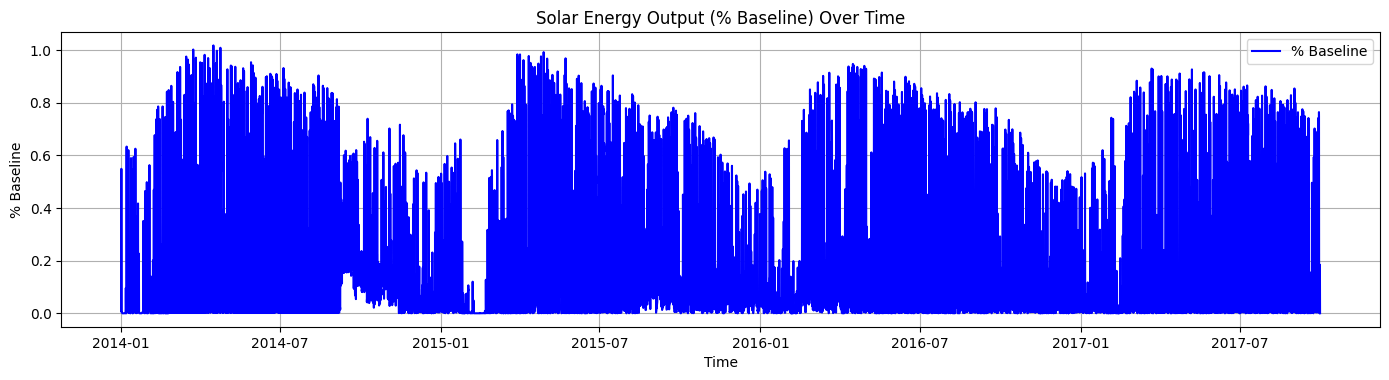

In [ ]:
# Plot time series for % Baseline and GHI
plt.figure(figsize=(14, 7))

# Plot % Baseline
plt.subplot(2, 1, 1)
plt.plot(train_merged['Timestamp'], train_merged['% Baseline'], color='blue', label='% Baseline')
plt.xlabel('Time')
plt.ylabel('% Baseline')
plt.title('Solar Energy Output (% Baseline) Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

This plot shows the variation of % Baseline over time. The x-axis represents the time, while the y-axis shows the % Baseline. This visualization helps to observe trends and patterns in the solar energy output data.

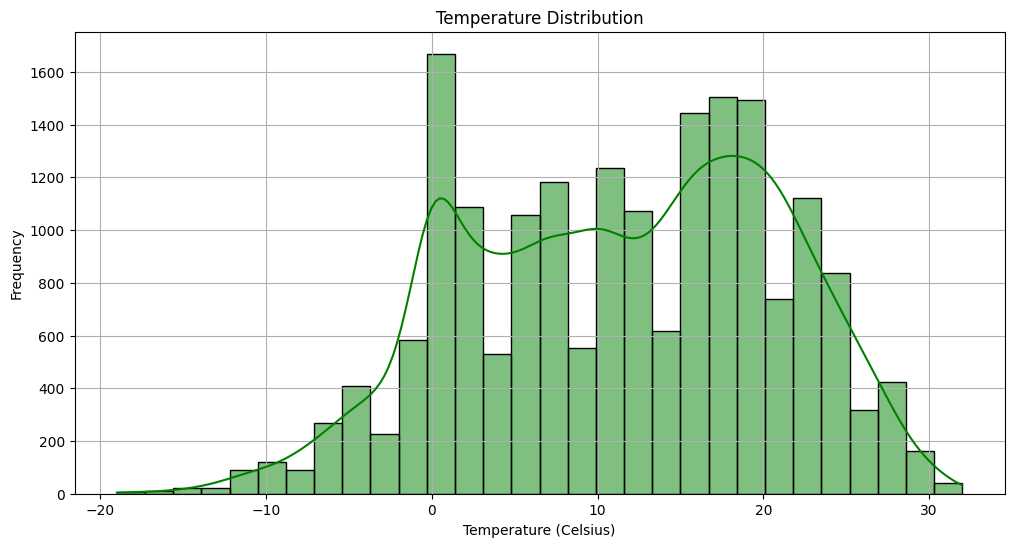

In [ ]:
# Histogram for temperature distribution
plt.figure(figsize=(12, 6))
sns.histplot(train_merged['Temperature'], bins=30, kde=True, color='green')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.title('Temperature Distribution')
plt.grid(True)
plt.show()

This histogram visualizes the distribution of temperature values. It includes a kernel density estimate (KDE) to show the probability density function. This plot helps in understanding the distribution and spread of temperature data.

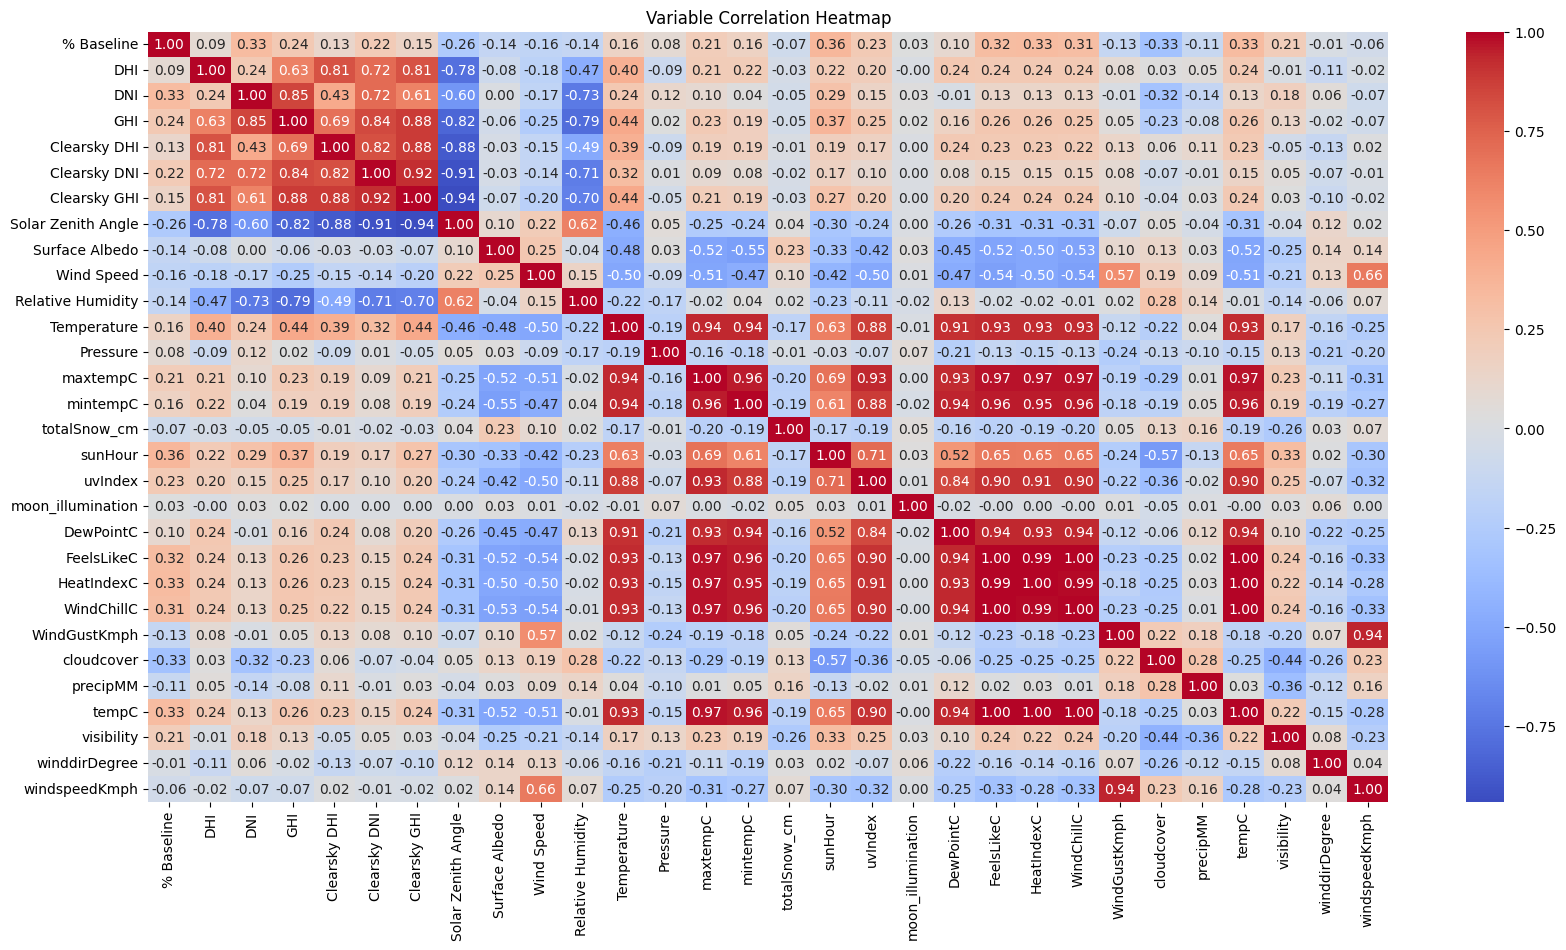

In [ ]:
# Calculate correlation matrix
correlation_matrix = train_merged[['% Baseline', 'DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
                    'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed', 'Relative Humidity',
                    'Temperature', 'Pressure', 'maxtempC', 'mintempC', 'totalSnow_cm',
                    'sunHour', 'uvIndex', 'moon_illumination', 'DewPointC', 'FeelsLikeC',
                    'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover',
                    'precipMM', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']].corr()

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Variable Correlation Heatmap')
plt.show()

The heatmap visualizes the correlation matrix of various variables. Each cell in the heatmap represents the correlation coefficient between two variables, which helps in understanding the relationships and dependencies between them.A color-coded matrix displaying correlation values, which helps in identifying strong and weak correlations between variables.

In [ ]:
# Scatter Matrix
subset_columns = ['% Baseline', 'DHI', 'DNI', 'GHI', 'Temperature', 'Wind Speed', 'uvIndex']

fig = px.scatter_matrix(
    train_merged,
    dimensions=subset_columns,
    color='% Baseline',
    title='Scatter Matrix of Selected Columns',
    labels={col: col for col in subset_columns}
)
fig.update_layout(
    template='plotly_white'
)
fig.show()

The scatter matrix (or pair plot) displays scatter plots for each pair of variables in the subset, colored by % Baseline. This helps in visualizing the pairwise relationships and interactions between selected features.A matrix of scatter plots showing how each pair of variables relates to each other, with % Baseline as the color dimension.

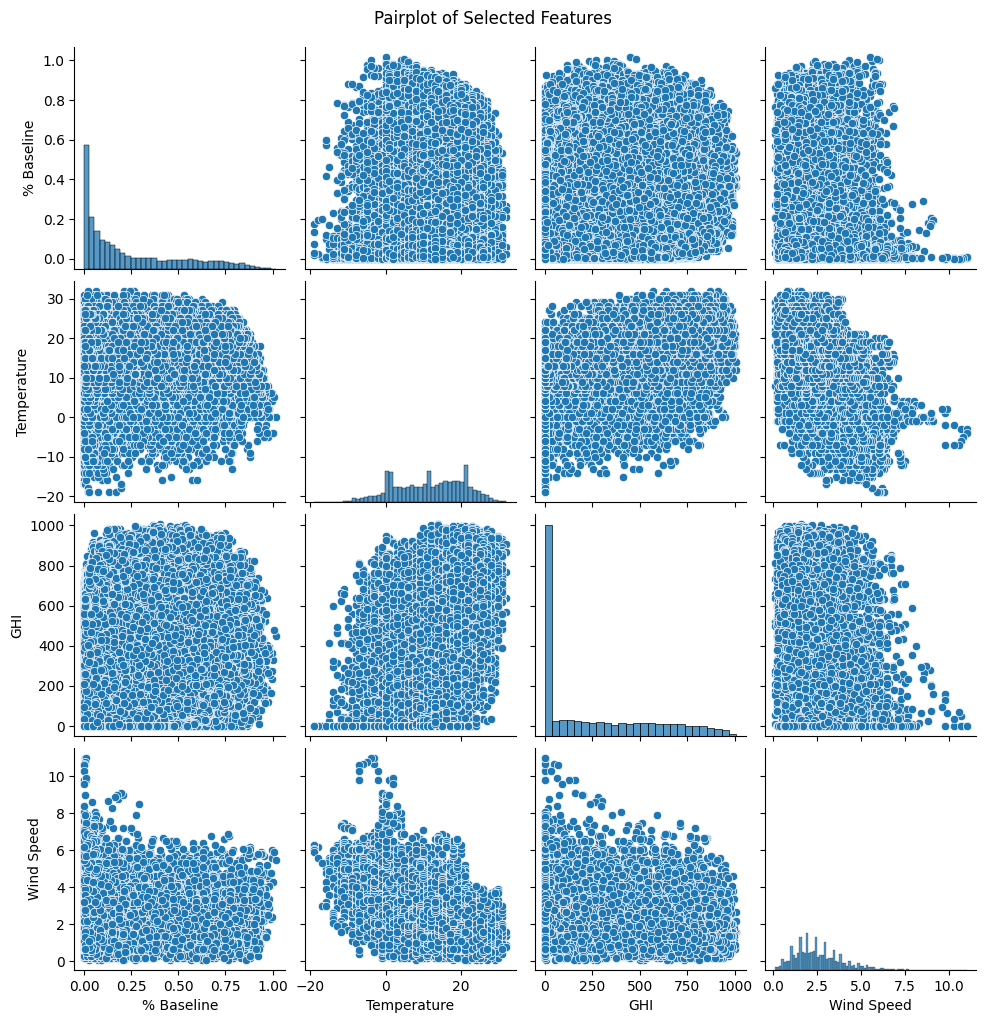

In [ ]:
# Pairplot Scatterplots
sns.pairplot(train_merged[['% Baseline', 'Temperature', 'GHI', 'Wind Speed']])
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()


The pairplot displays scatterplots for each pair of selected features, including histograms along the diagonal. It helps to visualize the relationships and distributions of pairs of features.

In [ ]:
# Summary statistics
summary_stats = train_merged[['% Baseline', 'DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
                    'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed', 'Relative Humidity',
                    'Temperature', 'Pressure', 'maxtempC', 'mintempC', 'totalSnow_cm',
                    'sunHour', 'uvIndex', 'moon_illumination', 'DewPointC', 'FeelsLikeC',
                    'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover',
                    'precipMM', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']].describe()
print(summary_stats)

         % Baseline           DHI           DNI           GHI  Clearsky DHI  \
count  18942.000000  17898.000000  17898.000000  17898.000000  17898.000000   
mean       0.242342     95.911778    273.771092    265.565203     70.321824   
std        0.256525    113.351016    351.014156    299.981246     67.811676   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.031800      0.000000      0.000000      0.000000      0.000000   
50%        0.134700     71.000000     16.000000    140.000000     74.000000   
75%        0.407700    141.000000    611.000000    507.000000    119.000000   
max        1.016900    476.000000   1019.000000   1006.000000    409.000000   

       Clearsky DNI  Clearsky GHI  Solar Zenith Angle  Surface Albedo  \
count  17898.000000  17898.000000        18942.000000    18942.000000   
mean     443.664991    349.700749           76.417798        0.209689   
std      382.568179    343.143039           33.997763        0.227794

This prints the summary statistics (e.g., mean, standard deviation, min, max, percentiles) for the specified columns. It provides an overview of the central tendency, dispersion, and shape of the data distribution.

## **DATA CLEANSING & DATA FILTERING**

In [ ]:
print(train_merged.shape)
print(test_merged.shape)
print(train_merged.columns)
print(test_merged.columns)
print(train_merged.isnull().sum())
print(test_merged.isnull().sum())


(18942, 45)
(1077, 45)
Index(['Timestamp', '% Baseline', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Cloud Type', 'Dew Point', 'Solar Zenith Angle', 'Surface Albedo',
       'Wind Speed', 'Relative Humidity', 'Temperature', 'Pressure',
       'date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph'],
      dtype='object')
Index(['Timestamp', '% Baseline', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'DHI', 'DNI', 'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Cloud Type', 'Dew Point', 'Solar Zenith Angle', 'Surface Albedo',
       'Wind Speed', 'Relative Humidity', 'Temperature', 'Pressure',
       'dat

This step involves checking for missing values (nulls) in training and testing datasets. Identifying columns with null values is crucial for deciding how to handle them—either by imputing, removing, or using other strategies.

<ipython-input-53-c25162e81ace>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-53-c25162e81ace>:12: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-53-c25162e81ace>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-53-c25162e81ace>:19: UserWarning:

FixedFormatter should only be used together with FixedLocator



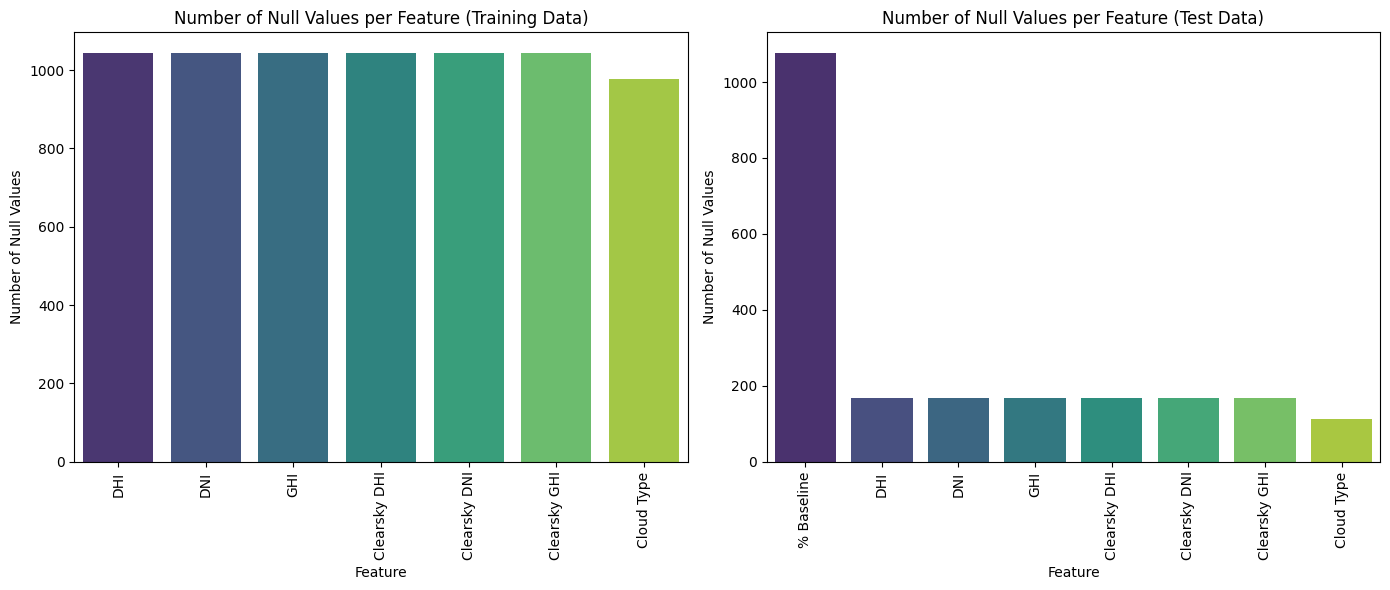

In [ ]:
# Calculate the count of null values per column
null_counts_train = train_merged.isnull().sum()
null_counts_test = test_merged.isnull().sum()
null_counts_train = null_counts_train[null_counts_train > 0]
null_counts_test = null_counts_test[null_counts_test > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for training data
sns.barplot(x=null_counts_train.index, y=null_counts_train.values, ax=axes[0], palette='viridis')
axes[0].set_title('Number of Null Values per Feature (Training Data)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)  # Rotate x-axis labels for readability
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Number of Null Values')

# Plot for test data
sns.barplot(x=null_counts_test.index, y=null_counts_test.values, ax=axes[1], palette='viridis')
axes[1].set_title('Number of Null Values per Feature (Test Data)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)  # Rotate x-axis labels for readability
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Number of Null Values')

plt.tight_layout()
plt.show()

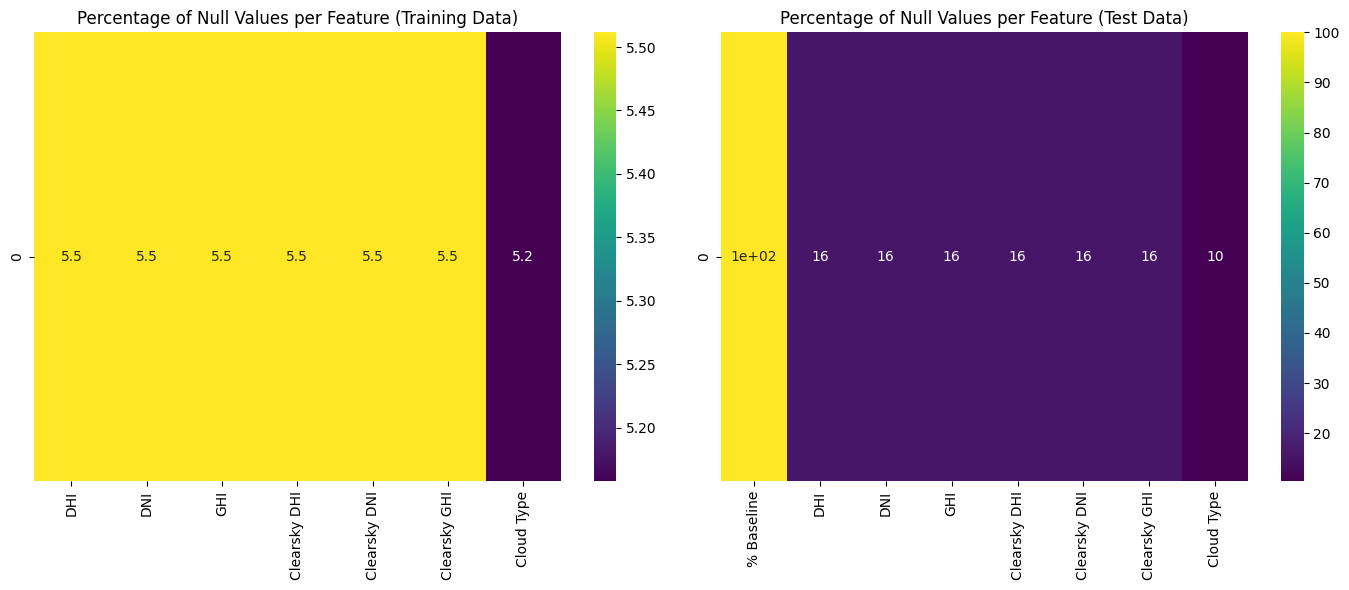

In [ ]:
# Calculate the percentage of null values per column
null_percentage_train = (train_merged.isnull().sum() / len(train_merged)) * 100
null_percentage_test = (test_merged.isnull().sum() / len(test_merged)) * 100
null_percentage_train = null_percentage_train[null_percentage_train > 0]
null_percentage_test = null_percentage_test[null_percentage_test > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for training data
sns.heatmap(null_percentage_train.to_frame().T, annot=True, cmap='viridis', ax=axes[0], cbar=True)
axes[0].set_title('Percentage of Null Values per Feature (Training Data)')

# Plot for test data
sns.heatmap(null_percentage_test.to_frame().T, annot=True, cmap='viridis', ax=axes[1], cbar=True)
axes[1].set_title('Percentage of Null Values per Feature (Test Data)')

plt.tight_layout()
plt.show()


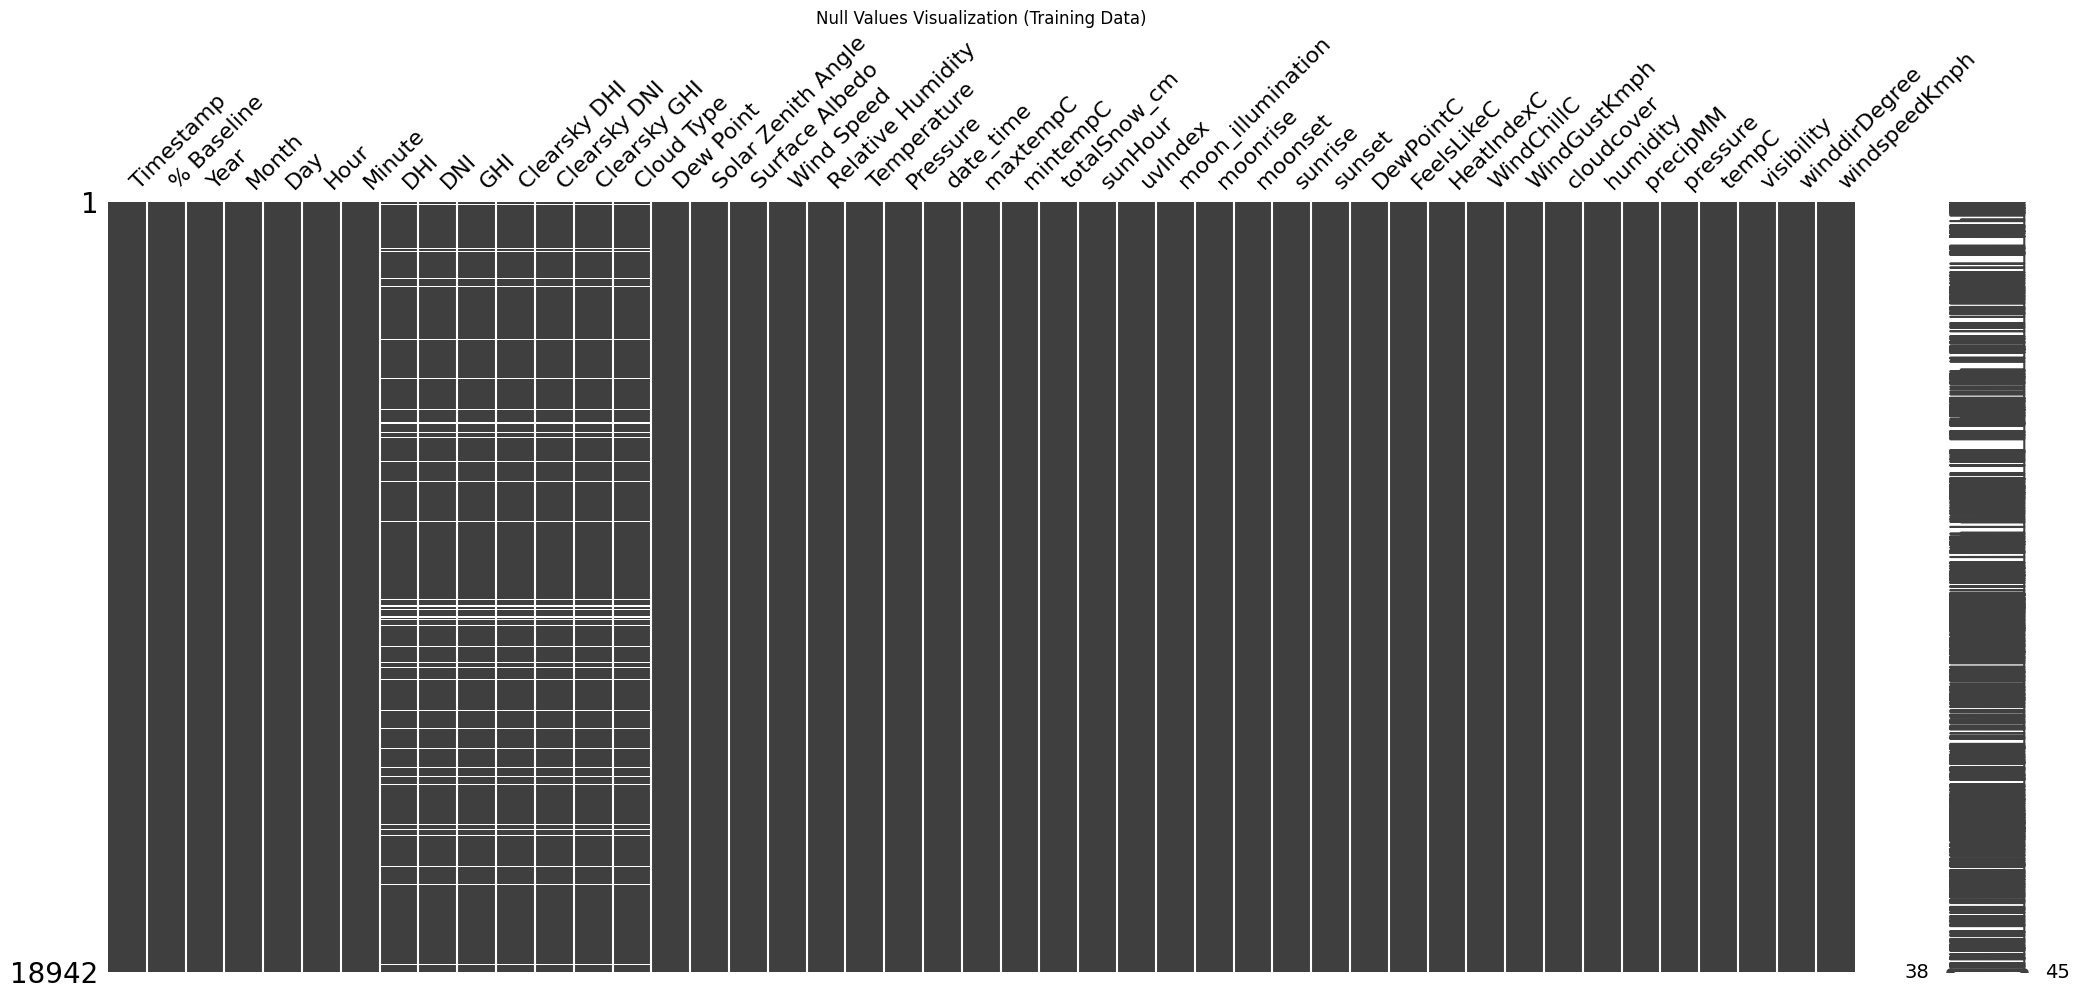

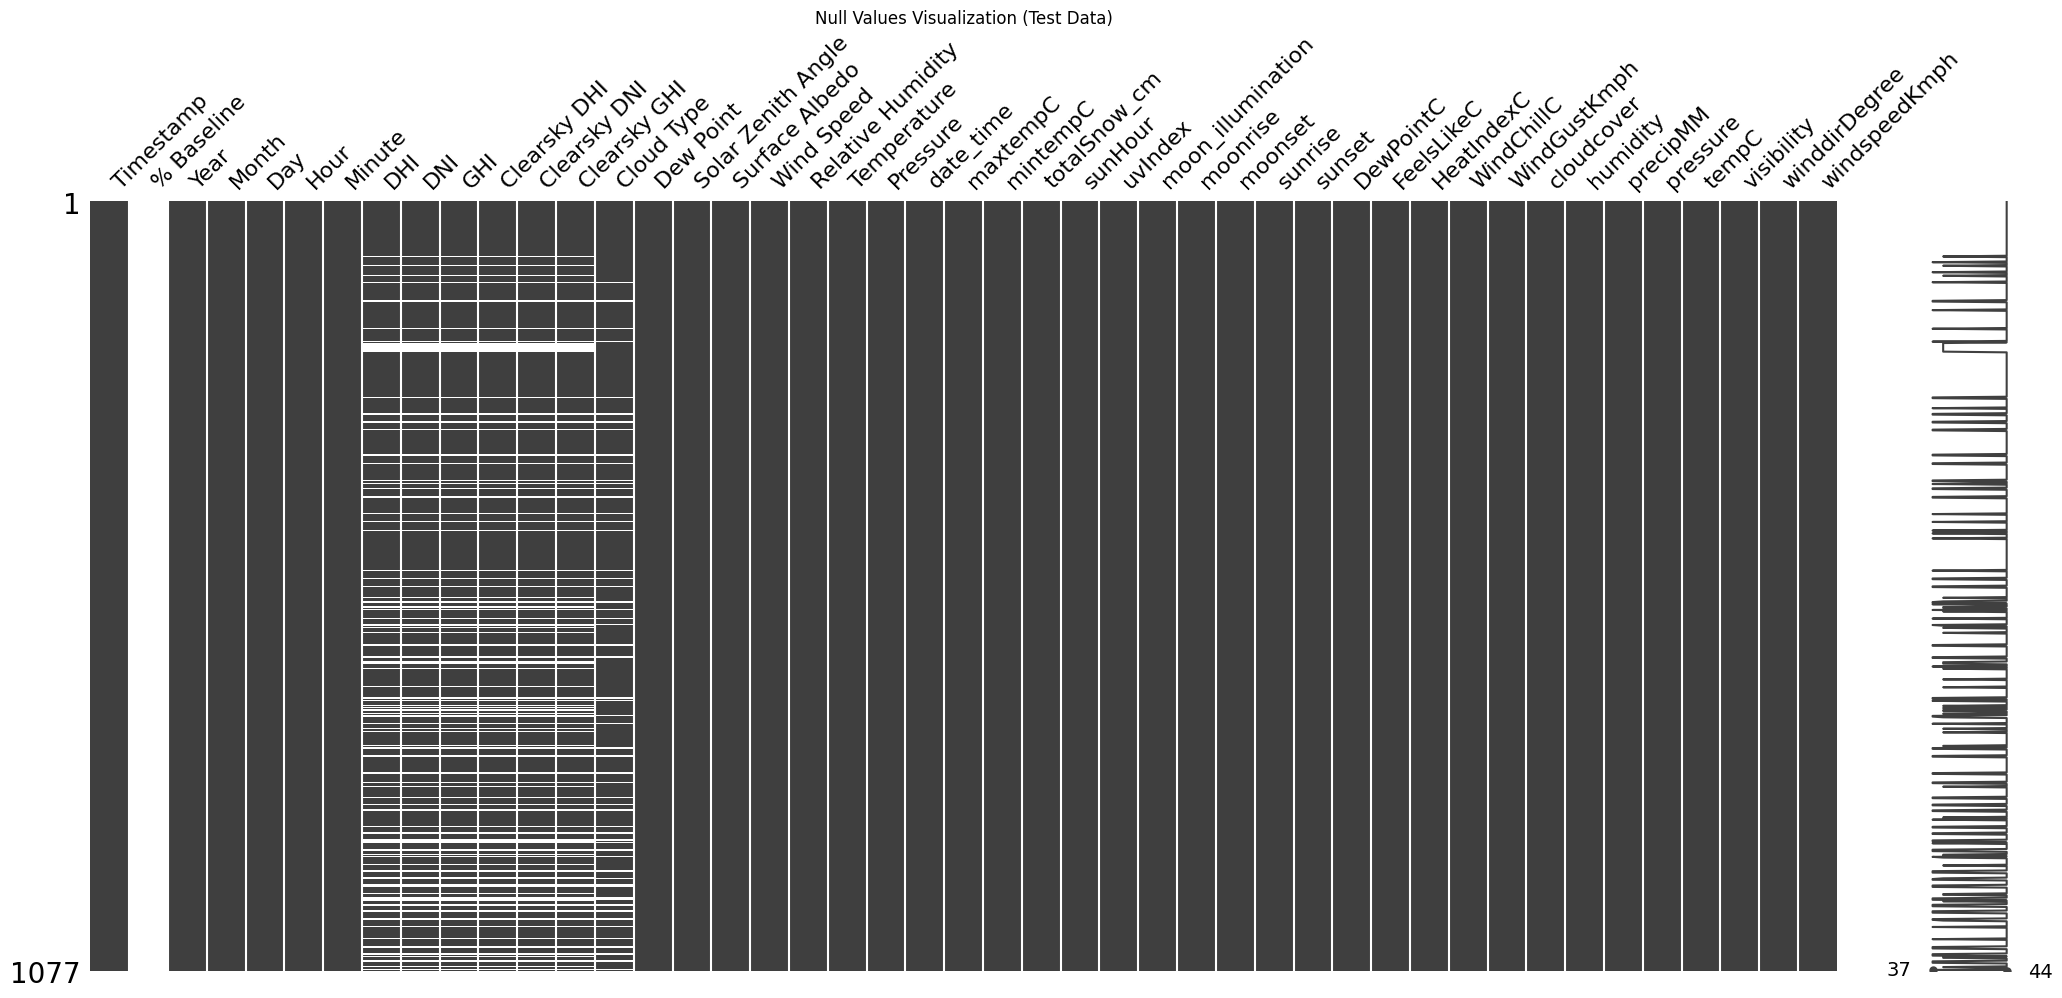

In [ ]:
# Using Missingno for Visualizing Null Values

# Visualization for training data
msno.matrix(train_merged)
plt.title('Null Values Visualization (Training Data)')
plt.show()

# Visualization for test data
msno.matrix(test_merged)
plt.title('Null Values Visualization (Test Data)')
plt.show()

In [ ]:
# Fill the missing value
numeric_cols = train_merged.select_dtypes(include=['number']).columns
non_numeric_cols = train_merged.select_dtypes(exclude=['number']).columns

train_merged[non_numeric_cols] = train_merged[non_numeric_cols].fillna('Unknown')
test_merged[non_numeric_cols] = test_merged[non_numeric_cols].fillna('Unknown')

train_merged[numeric_cols] = train_merged[numeric_cols].fillna(train_merged[numeric_cols].mean())
test_merged[numeric_cols] = test_merged[numeric_cols].fillna(test_merged[numeric_cols].mean())


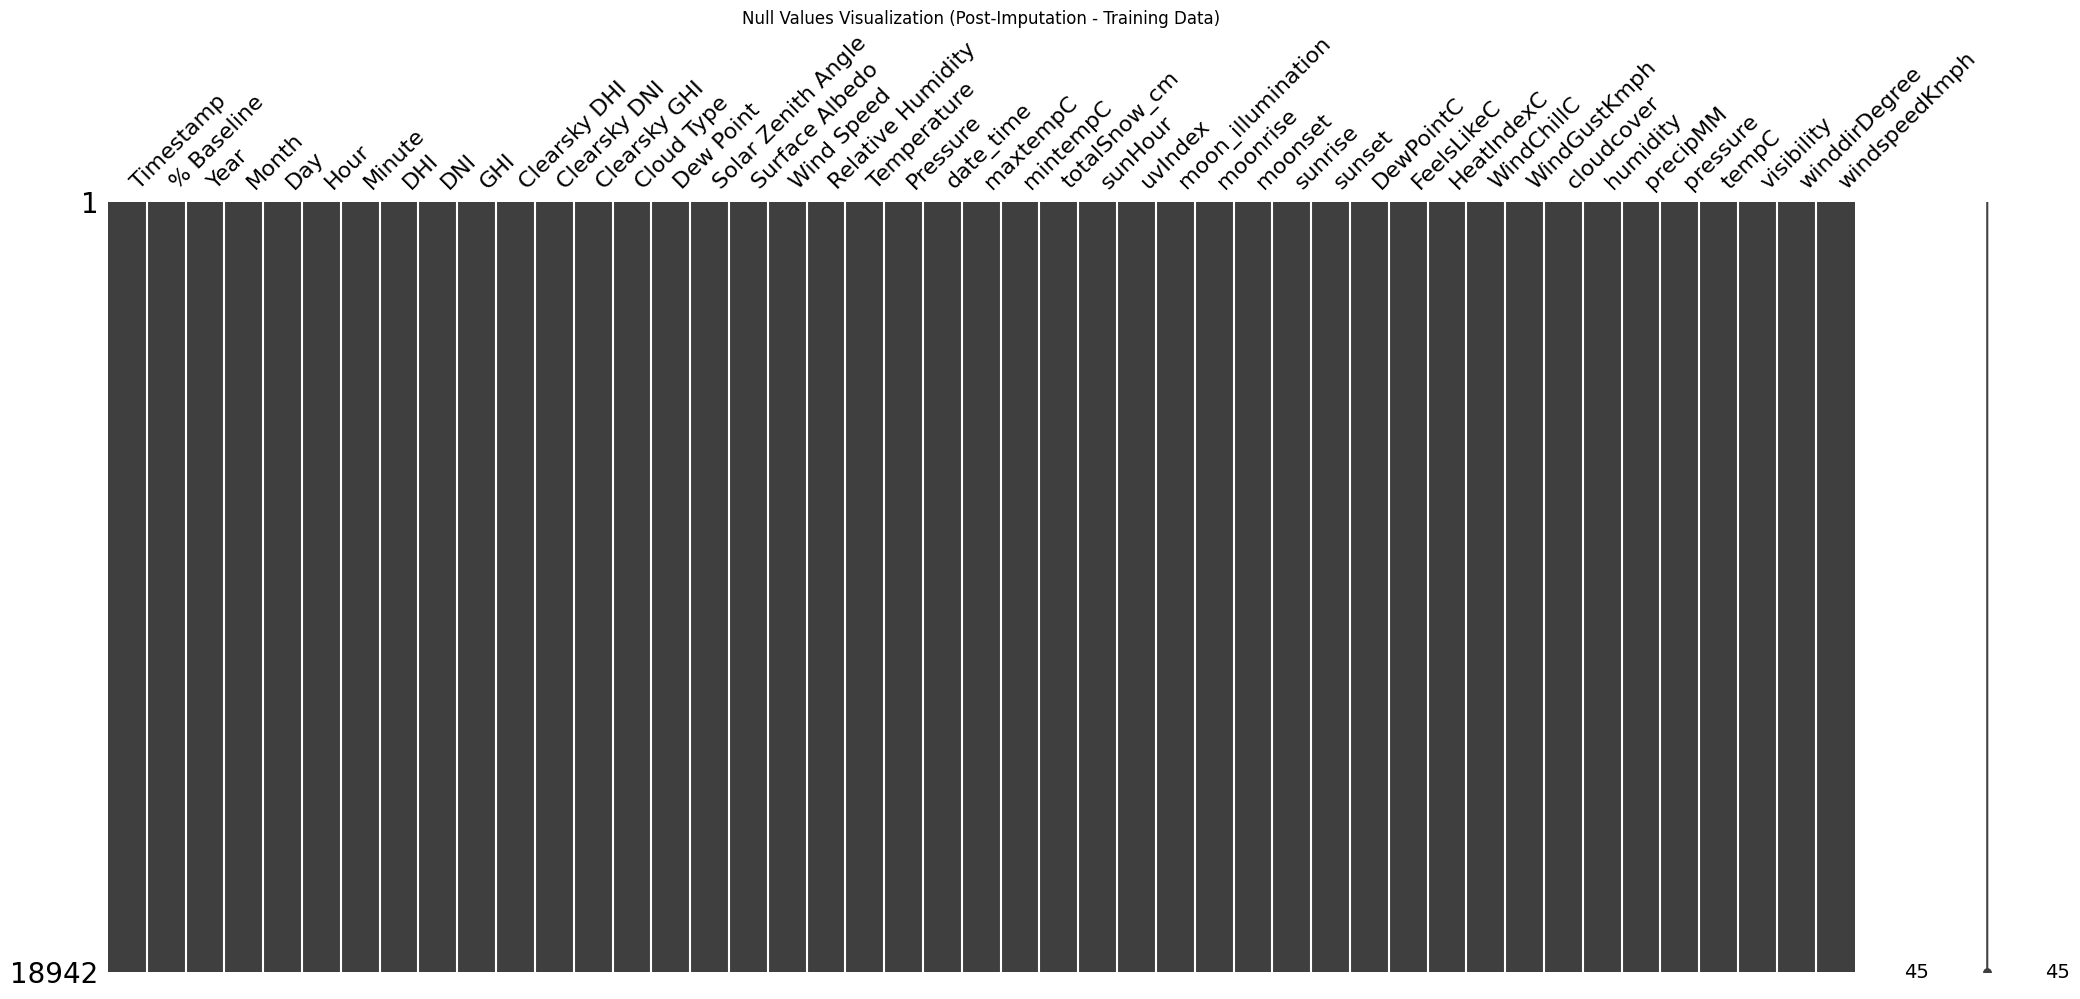

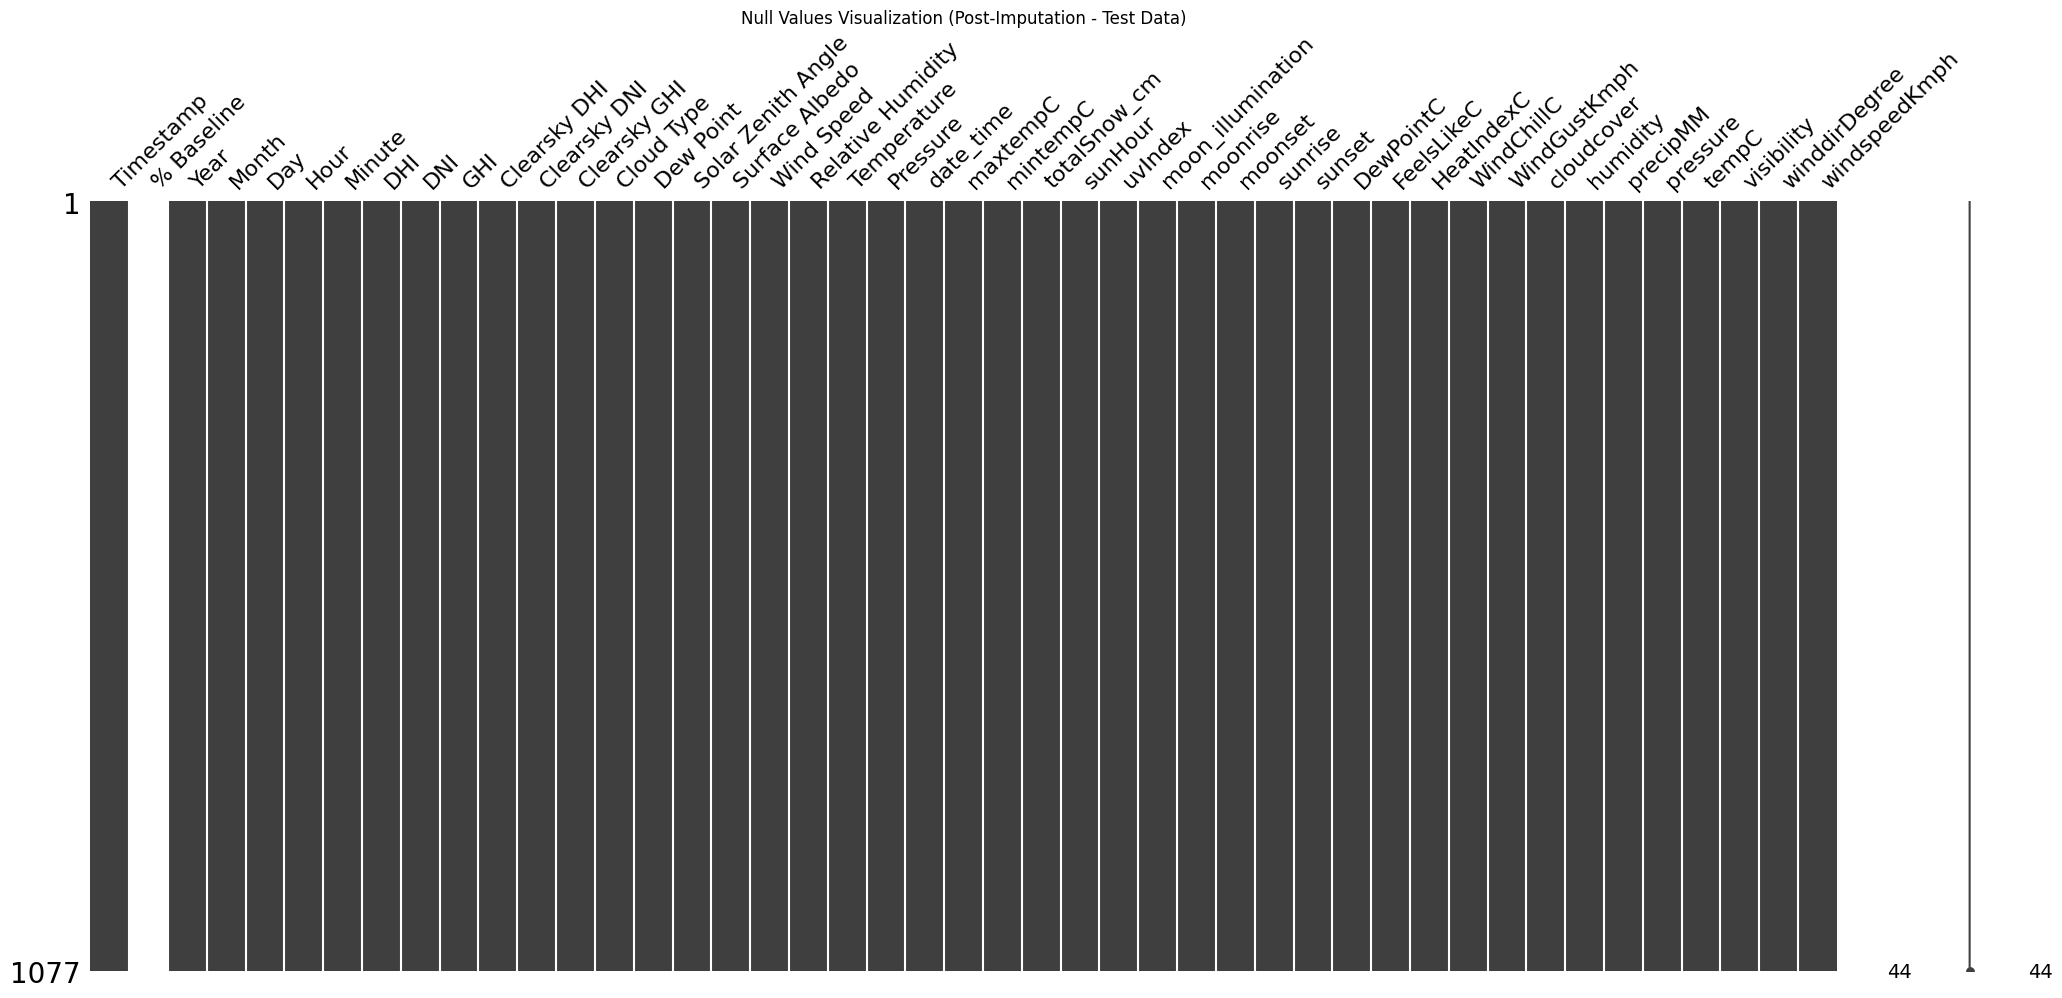

In [ ]:
# Visualize the Null Value Patterns Using Missingno

# Visualization for training data after imputation
msno.matrix(train_merged)
plt.title('Null Values Visualization (Post-Imputation - Training Data)')
plt.show()

# Visualization for test data after imputation
msno.matrix(test_merged)
plt.title('Null Values Visualization (Post-Imputation - Test Data)')
plt.show()

Missing values are handled by imputing numeric columns with the mean value and non-numeric columns with a placeholder ('Unknown'). This ensures that the dataset is complete and ready for modeling.

In [ ]:
# Check for duplicate data
print("Before checking for duplicates: ", train_merged.shape)
train_merged1 = train_merged[~train_merged.duplicated(keep='last')]
print("After checking for duplicates: ", train_merged1.shape)

print("Before checking for duplicates: ", test_merged.shape)
test_merged1 = test_merged[~test_merged.duplicated(keep='last')]
print("After checking for duplicates: ", test_merged1.shape)

Before checking for duplicates:  (18942, 45)
After checking for duplicates:  (18942, 45)
Before checking for duplicates:  (1077, 45)
After checking for duplicates:  (1077, 45)


In [ ]:
# Check the shape of the data
print("Number of training samples:", len(train_merged1))
print("Number of testing samples:", len(test_merged1))

Number of training samples: 18942
Number of testing samples: 1077


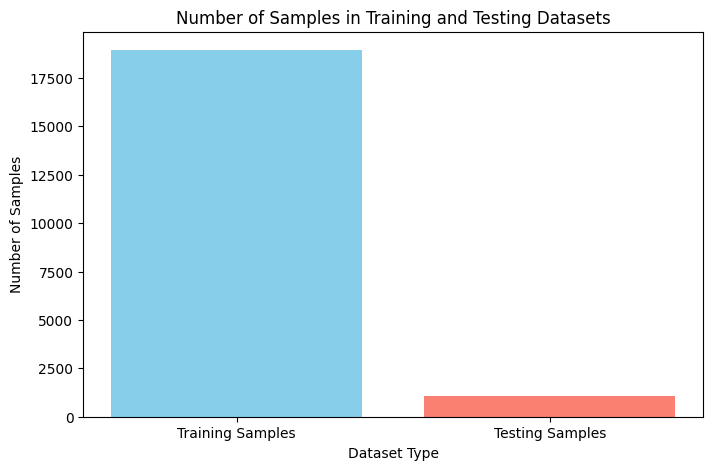

In [ ]:
# Number of data for training and testing
data_sizes = {
    'Training Samples': len(train_merged1),
    'Testing Samples': len(test_merged1)
}

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(data_sizes.keys(), data_sizes.values(), color=['skyblue', 'salmon'])
plt.xlabel('Dataset Type')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Training and Testing Datasets')
plt.show()

In [ ]:
# Check the type of the columns
print(non_numeric_cols)
print(numeric_cols)

Index(['Timestamp', 'Cloud Type', 'date_time', 'moonrise', 'moonset',
       'sunrise', 'sunset'],
      dtype='object')
Index(['% Baseline', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'DHI', 'DNI',
       'GHI', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Dew Point',
       'Solar Zenith Angle', 'Surface Albedo', 'Wind Speed',
       'Relative Humidity', 'Temperature', 'Pressure', 'maxtempC', 'mintempC',
       'totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'DewPointC',
       'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover',
       'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph'],
      dtype='object')


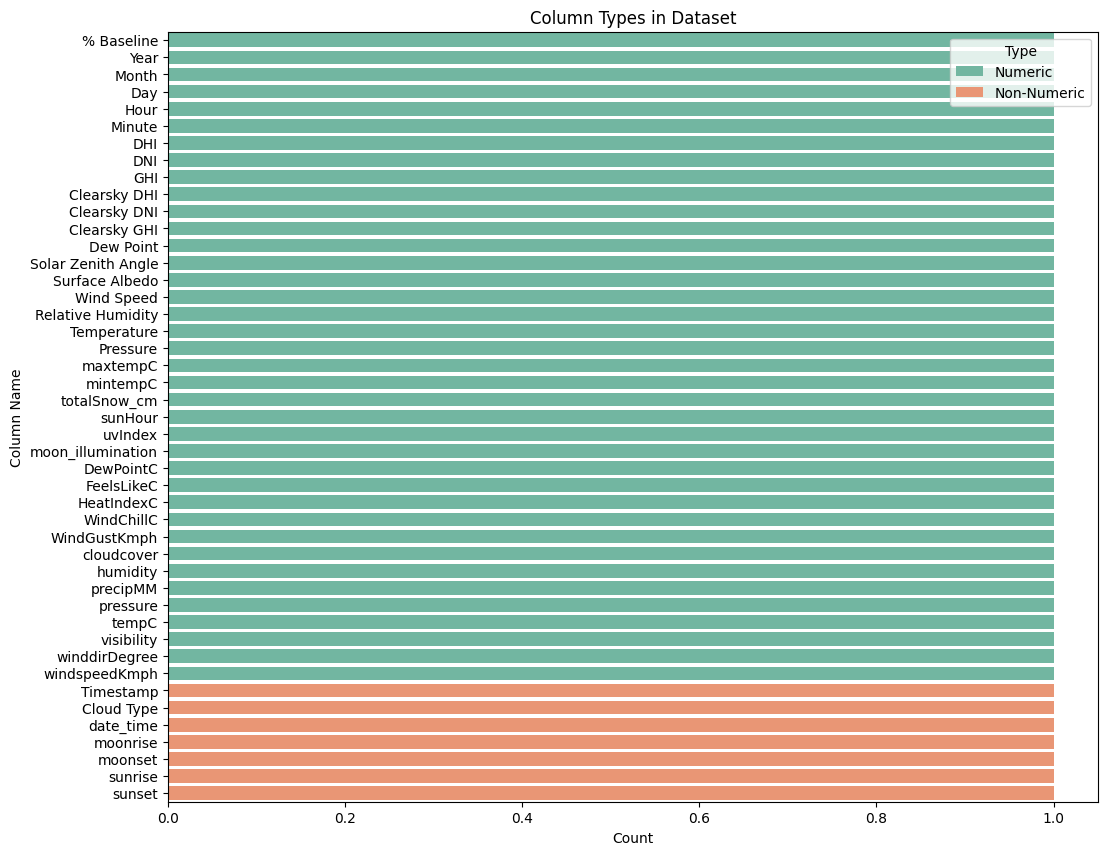

In [ ]:
# Data types for visualization
num_columns_data = [(col, 'Numeric') for col in numeric_cols]
non_num_columns_data = [(col, 'Non-Numeric') for col in non_numeric_cols]

df_columns = pd.DataFrame(num_columns_data + non_num_columns_data, columns=['Column Name', 'Type'])

# Plot
plt.figure(figsize=(12, 10))
sns.countplot(data=df_columns, y='Column Name', hue='Type', palette={'Numeric': '#66c2a5', 'Non-Numeric': '#fc8d62'})
plt.title('Column Types in Dataset')
plt.xlabel('Count')
plt.ylabel('Column Name')
plt.legend(title='Type')
plt.show()

<Axes: >

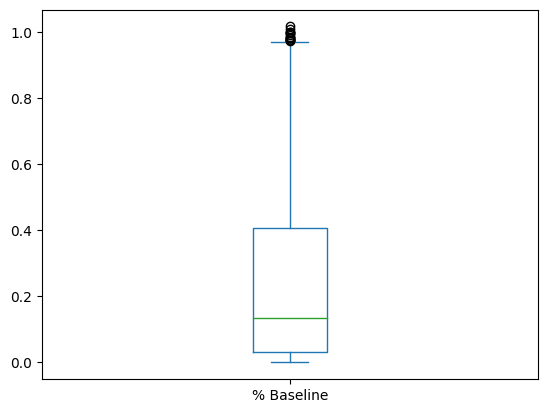

In [ ]:
# Outlier Checking
train_merged['% Baseline'].plot(kind='box')

In [ ]:
# Function to remove outliers
from pandas.api.types import is_numeric_dtype

def remove_outlier(df_in, col_name):
  df_out = df_in.copy()
  if is_numeric_dtype(df_in[col_name]):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)

    iqr = q3 - q1
    upper_bound = q3 + (iqr * 1.5)
    lower_bound = q1 - (iqr * 1.5)

    df_out = df_out.loc[(df_out[col_name] >= lower_bound) & (df_out[col_name] <= upper_bound)]

  return df_out

train_clean = remove_outlier(train_merged, "% Baseline")

print("Number of training rows before removing outliers: ", train_merged.shape[0])
print("Number of training rows after removing outliers: ", train_clean.shape[0])

Number of training rows before removing outliers:  18942
Number of training rows after removing outliers:  18926


<Axes: >

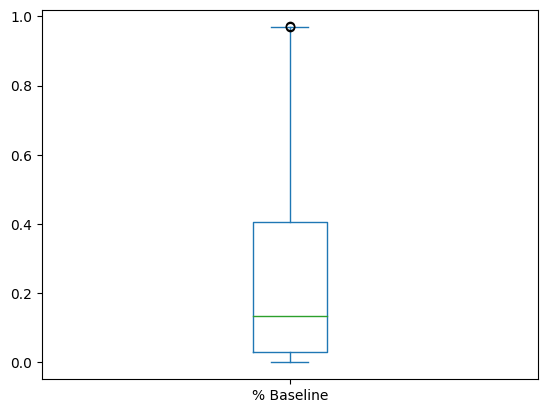

In [ ]:
# Check the outlier
train_clean['% Baseline'].plot(kind='box')

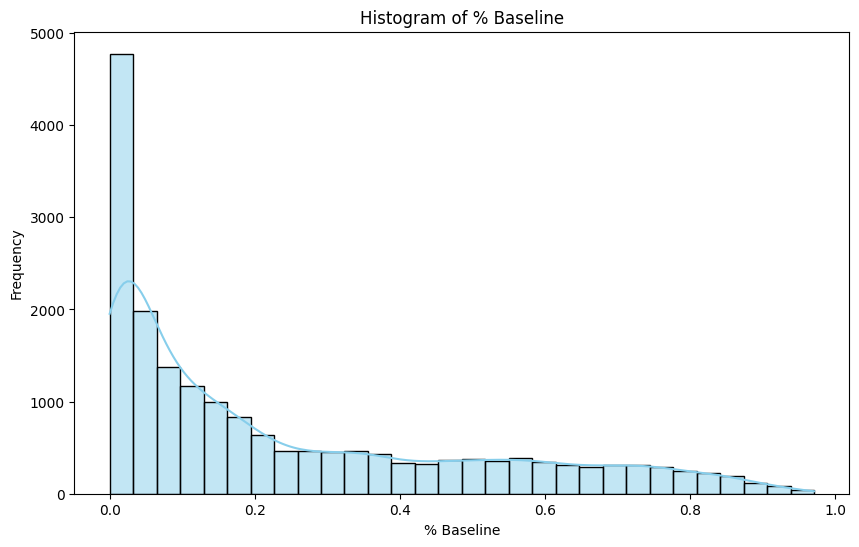

In [ ]:
# Histogram for '% Baseline' after being cleaned
plt.figure(figsize=(10, 6))
sns.histplot(train_clean['% Baseline'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of % Baseline')
plt.xlabel('% Baseline')
plt.ylabel('Frequency')
plt.show()


## **SPLIT & TRANSFORM DATA**

In [ ]:
# Drop columns
columns_to_drop = ['Timestamp', 'date_time', 'moonrise',
      'moonset', 'sunrise', 'sunset', 'Minute', 'Cloud Type', 'DNI',
      'Clearsky DHI', 'Clearsky GHI', 'Surface Albedo', 'Relative Humidity',
      'Pressure', 'totalSnow_cm', 'moon_illumination', 'DewPointC',
      'WindGustKmph', 'precipMM', 'winddirDegree', 'windspeedKmph', 'sunHour', 'cloudcover']

train_merged_dropped = train_clean.drop(columns_to_drop, axis=1)
test_merged_dropped = test_merged.drop(columns_to_drop, axis=1)

# % Baseline is the target
X = train_merged_dropped.drop(['% Baseline'], axis=1)
y = train_merged_dropped['% Baseline']

# Split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=3)

print("Size of X_train: ", X_train.shape)
print("Size of y_train: ", y_train.shape)
print("Size of X_val: ", X_val.shape)
print("Size of y_val: ", y_val.shape)

Size of X_train:  (15140, 21)
Size of y_train:  (15140,)
Size of X_val:  (3786, 21)
Size of y_val:  (3786,)


**Splitting the Dataset:**

The dataset was split into training and validation sets using an 80-20 ratio to ensure that the model had sufficient data for training while also being able to validate its performance.

In [ ]:
print(test_merged_dropped.shape)
print(test_merged_dropped.columns)

(1077, 22)
Index(['% Baseline', 'Year', 'Month', 'Day', 'Hour', 'DHI', 'GHI',
       'Clearsky DNI', 'Dew Point', 'Solar Zenith Angle', 'Wind Speed',
       'Temperature', 'maxtempC', 'mintempC', 'uvIndex', 'FeelsLikeC',
       'HeatIndexC', 'WindChillC', 'humidity', 'pressure', 'tempC',
       'visibility'],
      dtype='object')


In [ ]:
# One hot encoding and change data type

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
col_transformer = make_column_transformer(
    (OneHotEncoder(), cat_cols), remainder='passthrough'
)

# Data transformation
X_train_enc = col_transformer.fit_transform(X_train)
X_val_enc = col_transformer.transform(X_val)
test_data_enc = col_transformer.transform(test_merged_dropped)
X_cnn_enc = col_transformer.fit_transform(X)

df_train_enc = pd.DataFrame(X_train_enc, columns=col_transformer.get_feature_names_out())
df_val_enc = pd.DataFrame(X_val_enc, columns=col_transformer.get_feature_names_out())
df_test_enc = pd.DataFrame(test_data_enc, columns=col_transformer.get_feature_names_out())
df_cnn_enc = pd.DataFrame(X_cnn_enc, columns=col_transformer.get_feature_names_out())

# Remove the 'remainder__' prefix from column names
df_train_enc.columns = [col.replace('remainder__', '') for col in df_train_enc.columns]
df_val_enc.columns = [col.replace('remainder__', '') for col in df_val_enc.columns]
df_test_enc.columns = [col.replace('remainder__', '') for col in df_test_enc.columns]

numeric_columns = ['Year', 'Month', 'Day', 'Hour', 'DHI', 'GHI',
                  'Clearsky DNI', 'Solar Zenith Angle', 'Wind Speed',
                  'Temperature', 'maxtempC', 'mintempC', 'uvIndex', 'FeelsLikeC',
                  'HeatIndexC', 'WindChillC', 'tempC', 'visibility']

for col in numeric_columns:
    df_train_enc[col] = pd.to_numeric(df_train_enc[col], errors='coerce')
    df_val_enc[col] = pd.to_numeric(df_val_enc[col], errors='coerce')
    df_test_enc[col] = pd.to_numeric(df_test_enc[col], errors='coerce')


## **MODEL AND EVALUATION**

In [ ]:
# CNN Modeling
A = df_cnn_enc.values
b = y.values
A_train, A_val, b_train, b_val = train_test_split(A, b, test_size=0.2, random_state=3)

# Scaling data
scaler = StandardScaler()
A_train = scaler.fit_transform(A_train)
A_val = scaler.transform(A_val)

A_train = A_train.reshape((A_train.shape[0], A_train.shape[1], 1))
A_val = A_val.reshape((A_val.shape[0], A_val.shape[1], 1))

Convolutional Neural Network (CNN):

*   Conv1D Layer: A 1D convolutional layer with 64 filters and a kernel size of 3 was used to extract spatial features from the input sequences. The ReLU activation function was applied to introduce non-linearity.
*   MaxPooling1D Layer: A max-pooling layer followed the convolutional layer to downsample the input representation, reducing the dimensionality and highlighting the most important features.
*   Dropout Layer: To prevent overfitting, a dropout layer with a dropout rate of 0.2 was added. This layer randomly drops units during training, helping to generalize the model.





In [ ]:
# CNN-LSTM Model

model = Sequential()

# Add the CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(A_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Add the LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add the Dense layers
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

history = model.fit(A_train, b_train, epochs=60, batch_size=32, validation_data=(A_val, b_val))
loss, mae = model.evaluate(A_val, b_val)
print(f'Mean Absolute Error: {mae}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 19, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          23,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,857 (101.00 KB)

 Trainable params: 25,857 (101.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
474/474 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0532 - mae: 0.1780 - val_loss: 0.0281 - val_mae: 0.1274
Epoch 2/60
474/474 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0297 - mae: 0.1295 - val_loss: 0.0244 - val_mae: 0.1089
Epoch 3/60
474/474 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0253 - mae: 0.1157 - val_loss: 0.0210 - val_mae: 0.1055
Epoch 4/60
474/474 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0226 - mae: 0.1099 - val_loss: 0.0208 - val_mae: 0.0989
Epoch 5/60
474/474 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0209 - mae: 0.1046 - val_loss: 0.0169 - val_mae: 0.0922
Epoch 6/60
474/474 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0195 - mae: 0.1007 - val_loss: 0.0195 - val_mae: 0.0933
Epoch 7/60
474/474 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0177 - mae: 0.0945 - val_loss: 0.0154 - val_mae: 0.0883
Epoch 8/60
474/474 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0174 - mae: 0.0934 - val_loss: 0.0136 - val_mae: 0.0820
Epoch 9/60
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step -

Long Short-Term Memory (LSTM):

*   LSTM Layer: An LSTM layer with 50 units was introduced after the CNN layers to capture the temporal dependencies in the sequence data. This layer is crucial for understanding the time-series nature of the data.
*   Dropout Layer: Another dropout layer was added after the LSTM layer to further reduce the risk of overfitting.



In [ ]:
# Evaluate the model on validation data
loss, mae = model.evaluate(A_val, b_val)

print(f'Mean Absolute Error: {mae}')

# Predict with the model on test data
A_test = df_test_enc.values
A_test = scaler.transform(A_test)
A_test = A_test.reshape((A_test.shape[0], A_test.shape[1], 1))

predictions = model.predict(A_test)

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - mae: 0.0657
Mean Absolute Error: 0.06526868045330048
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


**Model Training and Evaluation:**

The model was compiled using the Adam optimizer, which is well-suited for deep learning models due to its adaptive learning rate. The loss function used was Mean Squared Error (MSE), which is appropriate for regression tasks.
The model was trained for 60 epochs with a batch size of 32. During training, both the training and validation losses were monitored to ensure that the model was learning effectively.
After training, the model was evaluated on the validation dataset. Key performance metrics such as Root Mean Squared Error (RMSE) were calculated to assess the model's accuracy.

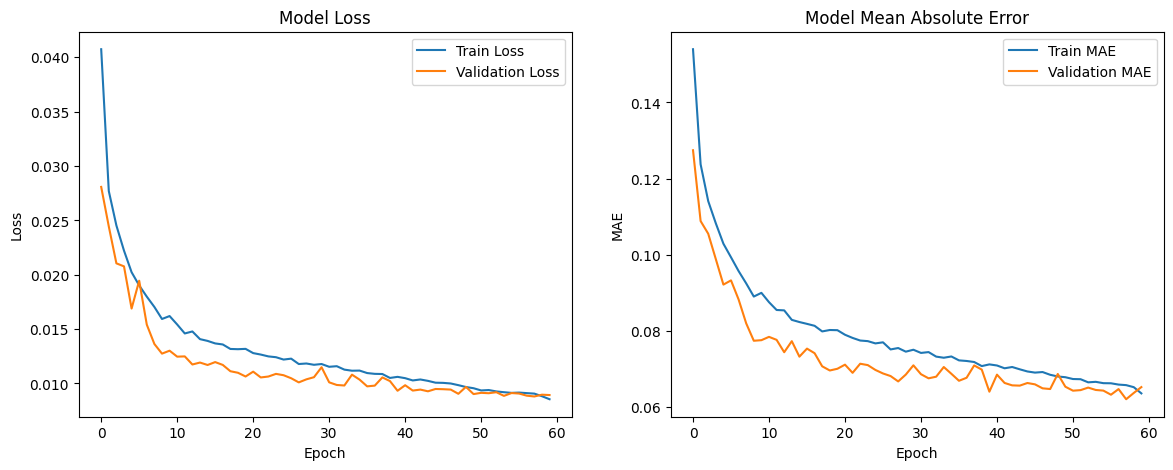

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.show()

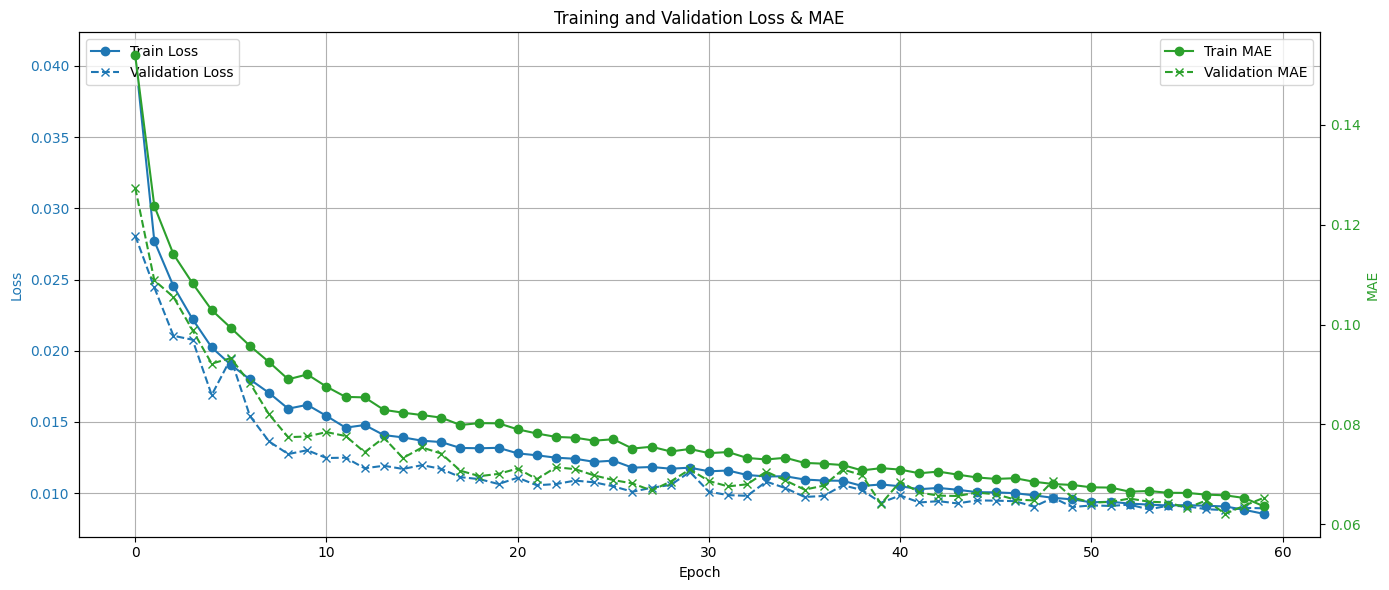

In [ ]:
# Plot Loss and MAE Together with Additional Enhancements
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Loss on the left y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(history.history['loss'], label='Train Loss', color='tab:blue', linestyle='-', marker='o')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='tab:blue', linestyle='--', marker='x')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.set_ylabel('MAE', color='tab:green')
ax2.plot(history.history['mae'], label='Train MAE', color='tab:green', linestyle='-', marker='o')
ax2.plot(history.history['val_mae'], label='Validation MAE', color='tab:green', linestyle='--', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

# Title and show plot
plt.title('Training and Validation Loss & MAE')
plt.tight_layout()
plt.show()


In [ ]:
model.save('cnn_model.h5')

In [ ]:
# Test with training data / validation data
cnn_predictions_train = model.predict(A_val)
mse_train = mean_squared_error(b_val, cnn_predictions_train)
mae_train = mean_absolute_error(b_val, cnn_predictions_train)

print("CNN Train MAE : ", mae_train)
print("CNN Train MSE : ", mse_train)
print("CNN Train Root Mean Squared Error : ", np.sqrt(mse_train))

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CNN Train MAE :  0.0652686832341673
CNN Train MSE :  0.008937345290247025
CNN Train Root Mean Squared Error :  0.09453753376435746


In this section, the trained Convolutional Neural Network (CNN) model was evaluated on the training/validation data to assess its performance. The model was used to generate predictions on the validation dataset (A_val), which were then compared to the actual values (b_val).

In [ ]:
df_results = pd.DataFrame(y_val)
df_results['Timestamp'] = train_merged['Timestamp']
df_results['CNN Prediction'] = cnn_predictions_train
df_results.head(10)

% Baseline           Timestamp  CNN Prediction
1925       0.0813 2014-05-26 18:00:00        0.087818
14766      0.4313 2016-11-23 10:00:00        0.342697
7092       0.0860 2015-06-08 18:00:00        0.060963
2395       0.0036 2014-06-21 20:00:00        0.043571
14514      0.0718 2016-11-02 08:00:00        0.100204
7788       0.0148 2015-07-21 19:00:00        0.049091
8588       0.0854 2015-09-10 07:00:00        0.066333
5010       0.0377 2014-12-19 08:00:00        0.069354
482        0.0003 2014-02-22 18:00:00        0.037091
7307       0.0170 2015-06-21 19:00:00        0.041651

In [ ]:
# Comparison of % Baseline and CNN Predictions over time from validation data (2014 - 2017)
df_results['Timestamp'] = pd.to_datetime(df_results['Timestamp'])

chart = alt.Chart(df_results).mark_line().encode(
    x='Timestamp:T',
    y='value:Q',
    color='variable:N'
).transform_fold(
    fold=['% Baseline', 'CNN Prediction'],
    as_=['variable', 'value']
).properties(
    title='Comparison of % Baseline and CNN Predictions Over Time',
    width=800,
    height=400
)

chart.interactive()


alt.Chart(...)

In [ ]:
# Comparison plot of % Baseline and CNN Predictions over time using scatter plot

scatter_plot = alt.Chart(df_results).mark_point().encode(
    x='% Baseline:Q',
    y='CNN Prediction:Q',
    color='variable:N',
    tooltip=['Timestamp:T', '% Baseline:Q', 'CNN Prediction:Q']
).transform_fold(
    fold=['% Baseline', 'CNN Prediction'],
    as_=['variable', 'value']
).properties(
    title='Scatter Plot of % Baseline vs CNN Predictions',
    width=800,
    height=400
)

scatter_plot.interactive()

alt.Chart(...)

In [ ]:
# Test with original data (test.csv)

cnn_test = df_test_enc
A_test = scaler.transform(cnn_test.values)
A_test = A_test.reshape((A_test.shape[0], A_test.shape[1], 1))


In this phase, the focus was on testing the trained CNN model using the original test dataset (test.csv). The test data, after being encoded, was scaled using the previously fitted scaler to ensure that it was within the same range as the training data. The scaled data was then reshaped to match the input dimensions expected by the CNN model.

In [ ]:
# Predict using original data (test.csv)
cnn_predictions = model.predict(A_test)
cnn_predictions = cnn_predictions.flatten()

df_results_test = pd.DataFrame(df_test_enc)
df_results_test['% Baseline'] = cnn_predictions

print(df_results_test.head(10))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
     Year  Month  Day  Hour   DHI    GHI  Clearsky DNI  Dew Point  \
0  2017.0   10.0  1.0   6.0   0.0    0.0           0.0        8.0   
1  2017.0   10.0  1.0   7.0   0.0    0.0           0.0        8.0   
2  2017.0   10.0  1.0   8.0   0.0    0.0           0.0        8.0   
3  2017.0   10.0  1.0   9.0   0.0    0.0           0.0        8.0   
4  2017.0   10.0  1.0  10.0   0.0    0.0           0.0        8.0   
5  2017.0   10.0  1.0  11.0  39.0  105.0         460.0        8.0   
6  2017.0   10.0  1.0  12.0  64.0  292.0         708.0        8.0   
7  2017.0   10.0  1.0  13.0  76.0  470.0         825.0        7.0   
8  2017.0   10.0  1.0  14.0  83.0  612.0         886.0        6.0   
9  2017.0   10.0  1.0  15.0  87.0  704.0         918.0        5.0   

   Solar Zenith Angle  Wind Speed  ...  mintempC  uvIndex  FeelsLikeC  \
0              133.20         2.7  ...       9.0      5.0         9.0   
1              124.69         2.7  ...       9.0      5

Once the data was properly formatted, it was fed into the CNN model to generate predictions. The model produced a set of predicted values, corresponding to the % Baseline of solar energy output. These predictions were then flattened into a one-dimensional array to facilitate further analysis.

A new DataFrame was created to store the original test data alongside the predicted % Baseline values. This allowed for easy comparison and analysis of the model’s performance on the test dataset. The first 10 rows of this DataFrame were printed to provide a quick overview of the predictions made by the model.

In [ ]:
# Plot predicted baseline using CNN model

df_results_test['Timestamp'] = pd.to_datetime(df_results_test[['Year', 'Month', 'Day', 'Hour']])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_results_test['Timestamp'],
    y=df_results_test['% Baseline'],
    mode='lines',
    name='Predicted Baseline',
    line=dict(color='red')
))

fig.update_layout(
    title='Solar Energy Output (Predicted Baseline) Over Time',
    xaxis_title='Time',
    yaxis_title='Predicted Baseline (CNN)',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
# Scatter plot predicted baseline using CNN-LSTM model
fig = px.scatter(df_results_test, x='Timestamp', y='% Baseline',
                 title='Solar Energy Output (Predicted Baseline) Over Time',
                 labels={'% Baseline': 'Predicted Baseline (CNN)', 'Timestamp': 'Time'},
                 template='plotly_white')

fig.update_layout(xaxis_title='Time', yaxis_title='Predicted Baseline (CNN)')
fig.show()

In [ ]:
if 'Timestamp' in df_results_test.columns:
    df_results_test['Timestamp'] = pd.to_datetime(df_results_test['Timestamp'])
    df_results_test['Timestamp'] = df_results_test['Timestamp'].dt.strftime('%b %-d, %Y %-I%p').str.replace('AM', 'am').str.replace('PM', 'pm')
else:
    print("Column 'Timestamp' not found")

df_results_test['% Baseline'] = df_results_test['% Baseline'].apply(lambda x: f'{x:.4f}')

# Save the DataFrame to a CSV file
df_results_test.to_csv('results_test_cnn.csv', index=False, columns=['Timestamp', '% Baseline'])
files.download('results_test_cnn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Predictions and Results:**

*   The trained model was used to make predictions on the test data. The predictions were then compared to the actual values to evaluate the model's performance.
*   The predicted values were formatted to four decimal places, ensuring consistency and precision in the results.
*   The timestamps in the results were formatted to a readable format, removing unnecessary leading zeros and standardizing the representation to match common date-time formats.





# **Conclusion:**

In this project, we successfully developed a hybrid CNN-LSTM model to predict time-series data, leveraging both convolutional and recurrent neural network capabilities. The CNN layers effectively extracted meaningful features from the sequence data, while the LSTM layers captured the temporal dependencies inherent in the data. This combination allowed for robust modeling of complex patterns and sequences.